In [1]:
%matplotlib inline

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

In [27]:
class MNIST_adv(Dataset):
    """
    A customized data loader for MNIST adversarial images.
    """
    def __init__(self,
                 original_label,
                 target_label):
        """ Intialize the MNIST dataset
        
        Args:
            - original_label: the label of natural image that 
                was used to create adversarial image
            - target_label: the label that the model was tricked
                into predicting
        """
        self.images = None
        self.labels = None
        self.filenames = []
        
        # read filenames
        path = os.path.join('MNIST_adversarial_FGVM', 
                                 'original_{}'.format(original_label), 
                                 'image*', 
                                 'target_{}.png'.format(target_label))
        filenames = glob.glob(path)
        
        for fn in filenames:
            # (filename, original_label, target_label) tuple
            self.filenames.append((fn, original_label, target_label))
                    
        self.len = len(self.filenames)
        
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        image_fn, original_label, target_label = self.filenames[index]
        image = Image.open(image_fn)
        
        # Transform image into Torch tensor
        # Also makes range between 0 and 1 (instead of 0 to 255)
        image = transforms.ToTensor()(image)
        
        # return image, original_label, and target_label
        return image, original_label, target_label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

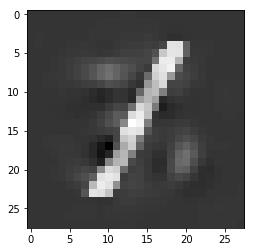

In [66]:
# Form a dataset of adversarial examples

# dataset of adversarial images originally of class 1 but targeted to class 3
data = MNIST_adv(1,3)
# trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

# Plot a few examples
j = 20
test_image = data[j][0]
plt.imshow(test_image[0], cmap='binary_r')
plt.show()

# Define architecture of dropout-defended model
This model should have same architecture as model for which adversarial images were generated -- except this model will have dropout layers

In [67]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3)
        self.conv3 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv4 = nn.Conv2d(20, 20, kernel_size=3)
        self.fc1 = nn.Linear(20*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d( self.conv2(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d( self.conv4(self.conv3(x)), 2))
        x = x.view(-1, 20*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
class Dropout_Net(nn.Module):
    def __init__(self, dropout_prob):
        super(Net, self).__init__()
        
        self.drop_prob = dropout_prob
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3)
        self.conv3 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv4 = nn.Conv2d(20, 20, kernel_size=3)
        self.fc1 = nn.Linear(20*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
#         # First conv layer
#         x = F.dropout(self.conv1(x), p=self.dropout_prob, training=self.training)
#         x = F.dropout(self.conv2(x), p=self.dropout_prob, training=self.training)
#         x = F.relu(F.max_pool2d(x,2))
        
#         # Second conv layer
#         x = F.dropout(self.conv3(x), p=self.dropout_prob, training=self.training)
#         x = F.dropout(self.conv4(x), p=self.dropout_prob, training=self.training)
#         x = F.relu(F.max_pool2d(x,2))

#         # FC conv layer
#         x = x.view(-1, 20*4*4)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, p=self.dropout_prob, training=self.training)
#         x = F.relu(self.fc2(x))
#         x = F.dropout(x, p=self.dropout_prob, training=self.training)
        
#         return F.log_softmax(x, dim=1)
        
        x = F.relu(F.max_pool2d( self.conv2(self.conv1(x)), 2))
        x = F.dropout(x, p=self.dropout_prob, training=self.training)
        
        x = F.relu(F.max_pool2d( self.conv4(self.conv3(x)), 2))
        x = F.dropout(x, p=self.dropout_prob, training=self.training)

        x = x.view(-1, 20*4*4)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_prob, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, p=self.dropout_prob, training=self.training)
        return F.log_softmax(x, dim=1)
        
        
        # original
#         x = F.relu(F.max_pool2d( self.conv2(self.conv1(x)), 2))
#         x = F.relu(F.max_pool2d( self.conv4(self.conv3(x)), 2))
#         x = x.view(-1, 20*4*4)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1)


In [ ]:
# Create the MNIST dataset. 
# transforms.ToTensor() automatically converts PIL images to
# torch tensors with range [0, 1]
trainset = MNIST(
    root='mnist_png/training',
    preload=True, transform=transforms.ToTensor(),
)
# Use the torch dataloader to iterate through the dataset
trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

# load the testset
testset = MNIST(
    root='mnist_png/testing',
    preload=True, transform=transforms.ToTensor(),
)
# Use the torch dataloader to iterate through the dataset
testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)

In [ ]:
print(len(trainset))
print(len(testset))

### Visualize the dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainset_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(16)))

In [ ]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device(cuda if use_cuda else "cpu")
print(device)

### Define a Conv Net


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [ ]:
def train(epoch, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        test()

In [ ]:
def test():
    model.eval()  # set evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testset_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset_loader.dataset),
        100. * correct / len(testset_loader.dataset)))

In [ ]:
train(5)  # train 5 epochs should get you to about 97% accuracy

## 2. Save the model (model checkpointing)

Now we have a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [ ]:
# create a brand new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
test()

### Define a training loop with model checkpointing

In [ ]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()
    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [ ]:
train_save(5, 500, 100)

In [ ]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('mnist-4690.pth', model, optimizer)
# should give you the final model accuracy
test()

## 3. Fine-tune a model

Sometimes you want to fine-tune a pretrained model instead of training a model from scratch. For example, if you want to train a model on a new dataset that contains natural images. To achieve the best performance, you can start with a model that's fully trained on ImageNet and fine-tune the model.

Finetuning a model in PyTorch is super easy! First, let's find out what we saved in a checkpoint

In [ ]:
# What's in a state dict?
print(model.state_dict().keys())

### Finetune the fc layers

Now say we want to load the conv layers from the checkpoint and train the fc layers. We can simply load a subset of the state dict with the selected names

In [ ]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)
        
model = Net().to(device)
model.load_state_dict(model_state)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train(1)  # training 1 epoch will get you to 93%!

### Import pretrained weights in a different model

We can even use the pretrained conv layers in a different model.

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

model = SmallNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)
        
model.load_state_dict(model_state)

In [ ]:
train(1)  # training 1 epoch will get you to 93%!